# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# using SQLite Table to read data.
con = sqlite3.connect('gdrive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [10]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## Taking 30k datapoints

In [17]:
#Before starting the next phase of preprocessing lets see the number of entries left
final = final.sample(30000)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

1    25266
0     4734
Name: Score, dtype: int64

In [18]:
final = final.sort_values('Time',ascending = True)
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...
346033,374335,B00004CI84,A3L5V40F14R2GP,AARON,0,0,1,1004054400,Beetlejuice! Beetlejuice! Beatlejuice!,Winona Ryder is HOT! HOT! HOT! as the gothic d...
346031,374333,B00004CI84,A1CZICCYP2M5PX,Christian Pelchat,0,0,1,1013040000,An entertaining odd fantasy comedy.,When Two Couple (Geena Davis & Alec Baldwin) d...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
124630,135144,B001KWK1N8,A3FS8HDE2BTD5Z,"C. Boeck ""cebii""",1,1,1,1068595200,really the best,I buy this at our neighborhood supermarket. I...
62127,67497,B0000D9N7U,AQFIH82DRPMW,Patrick O'Brien,26,26,1,1068940800,Try It!,"If you've never had real Swiss fondue, you're ..."
118126,128130,B0000CG4I0,A23GFTVIETX7DS,Debbie Lee Wesselmann,23,25,1,1069027200,100% Kona - not easy to find!,Many coffee brands that advertise their beans ...
223527,242382,B0000CNU0A,ALYOQ8324079Y,"Maddi Hausmann Sojourner ""madhaus""",9,9,1,1070236800,instant Japanese soup base,"Not as quick as those classic Herb-ox cubes, b..."
94002,102194,B0000UD67Y,A18O1KPT80HUDQ,"K. Moore ""collegian""",0,0,1,1072656000,Simply Chai,I've tried many of packaged Chai products - li...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
I love this product.  All I care about is my health, (breast cancer survivor). Yes, of course I have bits in between my teeth afterwards, so what. I have already recommended this product to two friends.  It does not bloat me out, it is zapped in a blender with almond milk, a banana, goji berries and a few strawberries and a bit of pineapple.<br /><br />I know that I am getting a good and healthy breakfast, plus I have lost a few pounds in the last two weeks as well.  I also have the hemp seeds and oil on a salad at lunchtime.<br /><br />Thank you Nutiva!
We are always on the lookout fo

In [20]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


In [21]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books & songs when I did my  student teaching for preschoolers & turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &  2.  The tradition lives on!
I love this product.  All I care about is my health, (breast cancer survivor). Yes, of course I have bits in between my teeth afterwards, so what. I have already recommended this product to two friends.  It does not bloat me out, it is zapped in a blender with almond milk, a banana, goji berries and a few strawberries and a bit of pineapple.I know that I am getting a good and healthy breakfast, plus I have lost a few pounds in the last two weeks as well.  I also have the hemp seeds and oil on a salad at lunchtime.Thank you Nutiva!
We are always on the lookout for a good gluten free pasta. This one

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

We are always on the lookout for a good gluten free pasta. This one cooks up al dente very nicely, and my son who is quite selective, likes it. Would make a good pasta for pasta salad since it can hold up to sauces well and to reheating, too.


In [24]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children  &amp;    The tradition lives on!


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

We are always on the lookout for a good gluten free pasta This one cooks up al dente very nicely and my son who is quite selective likes it Would make a good pasta for pasta salad since it can hold up to sauces well and to reheating too 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 30000/30000 [00:09<00:00, 3013.58it/s]


In [28]:
preprocessed_reviews[1500]

'always lookout good gluten free pasta one cooks al dente nicely son quite selective likes would make good pasta pasta salad since hold sauces well reheating'

## Splitting the data

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.3,random_state = 42)
print('AFter splitting:\n')
print('Size of training data is:',len(X_train))
print('Size of test data is:',len(X_test))

AFter splitting:

Size of training data is: 21000
Size of test data is: 9000


In [30]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10)
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=10)


In [31]:
for train,cv in tscv.split(X_train):
    print('SIZE OF TRAINING SET:',train.shape,'SIZE OF VALIDATION SET',cv.shape)

SIZE OF TRAINING SET: (1910,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (3819,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (5728,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (7637,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (9546,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (11455,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (13364,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (15273,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (17182,) SIZE OF VALIDATION SET (1909,)
SIZE OF TRAINING SET: (19091,) SIZE OF VALIDATION SET (1909,)


# [4] Featurization

## BAG OF WORDS

In [32]:
bow_vect = CountVectorizer(min_df = 10,max_features = 500)
bow_vect.fit(X_train)

train_bow = bow_vect.transform(X_train)
test_bow = bow_vect.transform(X_test)

print('AFTER VECTORIZATION :\n')
print('training set:',train_bow.shape)
print('test set:',test_bow.shape)

AFTER VECTORIZATION :

training set: (21000, 500)
test set: (9000, 500)


## TFIDF

In [0]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2),max_df = 10,max_features = 500)
tfidf_vect.fit(X_train)

train_tfidf = tfidf_vect.transform(X_train)
test_tfidf = tfidf_vect.transform(X_test)

## WORD 2 VECTOR

## <font color='red'> Average Word 2 Vector</font>

In [0]:
s_train = []
for sent in X_train:
    s_train.append(sent.split())
#preparing the training data for  word to vector vectorization    
    
s_test = []
for sent in X_test:
    s_test.append(sent.split())
#preparing the test data for word to vector fatorization

In [34]:
w2v_model=Word2Vec(s_train,min_count=5,size=50, workers=4)# min_count = 5 considers only words that occured atleast 5 times

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


number of words that occured minimum 5 times  9060


In [59]:
#Average word2vec
#computing average word to vector for training data 

train_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_avgw2v.append(sent_vec)

print(len(train_avgw2v))#number of datapoints in training set

100%|██████████| 21000/21000 [00:27<00:00, 776.18it/s]

21000


In [60]:
#computing average word to vector for test data 

test_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(s_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_avgw2v.append(sent_vec)

print(len(test_avgw2v))#number of datapoints in test set

100%|██████████| 9000/9000 [00:12<00:00, 742.04it/s]

9000


## <font color='green'> TFIDF Word 2 Vector</font>

In [0]:
vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10,max_features = 500)#initializing the tfidf vectorizer 

tf_idf = vect.fit_transform(X_train)#fitting the training data
dictionary = dict(zip(vect.get_feature_names(), list(vect.idf_)))#zipping both of the feature names and vectorizer idf scores

In [0]:

tfidf_feat = vect.get_feature_names() 

In [37]:
train_tfidfw2v = []; # the tfidf-w2v for each sentence/review in training set is stored in this list
row=0;
for sent in tqdm(s_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidfw2v.append(sent_vec)
    row += 1    
print(len(train_tfidfw2v))

100%|██████████| 21000/21000 [00:35<00:00, 597.39it/s]

21000


In [38]:
test_tfidfw2v = []; # the tfidf-w2v for each sentence/review in test set is stored in this list
row=0;
for sent in tqdm(s_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidfw2v.append(sent_vec)
    row += 1
    
print(len(test_tfidfw2v))


100%|██████████| 9000/9000 [00:15<00:00, 577.08it/s]

9000


<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.2] RBF SVM

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameter = [10**i for i in range(-5,5)]
#hyperparameter C will be tuned in this range
params = {'C':parameter}
tscv = TimeSeriesSplit(n_splits = 5)
#for time  series cross validation

In [0]:
#function for findind the optimal hyperparameters

def svm(train_set,train_y):
    model = GridSearchCV(SVC(kernel = 'rbf',gamma = 'auto',probability = True),param_grid = params,cv = tscv,\
                        scoring = 'roc_auc',verbose = 1,return_train_score = True)
    #we will set gamma to 'auto' to fit the model with less erros,and also returning the probabilites to calculate
    #feature importance
    model.fit(train_set,train_y)
    return model

In [0]:
#plots for tuning
def errors(model):
    best_C = model.best_params_
    #getting the best hyperparameter
    print('best hyperparameter is :',best_C)
    print('best cross validation score is:',model.best_score_)
    t_auc =  model.cv_results_['mean_train_score']
    #adding all train and test score
    cv_auc = model.cv_results_['mean_test_score']
    
    
    sns.set_style('darkgrid')
    plt.figure(figsize = (15,6))
    plt.plot(parameter,t_auc,'r',label = 'Training AUC')#plotting the training score
    plt.plot(parameter,cv_auc,'b',label = 'Cross Validation AUC')#plotting the test score
    plt.xscale('log')
    plt.xlabel('Hyperparameters',fontsize  =18)
    plt.ylabel('AUC Scores',fontsize = 18)
    plt.title('AUC vs Hyperparameter',fontsize = 18)
    plt.legend('best')#displaying the best position of the labels
    plt.show()
    return best_C
    
    

In [0]:
#fitting the best classifier

from sklearn.metrics import roc_auc_score

def best_classifier(clf,train_set,train_y,test_set,test_y):
    
    #clf.fit(train_set,train_y)
    
    train_pred = clf.predict(train_set)#predicting the values on train data
    test_pred  = clf.predict(test_set)#predicting the values on test data
    
    p_train = clf.predict_proba(train_set)[:,1]#predicting the probability values on train data
    p_test = clf.predict_proba(test_set)[:,1]#predicting the probability values on test data 
    
    t_auc = roc_auc_score(train_y,p_train)#training auc after fitting best hyperparameter
    cv_auc = roc_auc_score(test_y,p_test)#test score after fitting the best hyperparameter
    
    print('AUC on Training data is:',t_auc)
    print('AUC on test data is:',cv_auc)
    return t_auc,cv_auc,p_train,p_test,train_pred,test_pred
    
    
    

In [0]:
#plotting the roc on train and test dat

from sklearn.metrics import roc_curve

def plot_roc(train_y,test_y,train_proba,test_proba,tr_auc,te_auc):
    tr_fpr,tr_tpr,_ = roc_curve(train_y,train_proba)
    te_fpr,te_tpr,_ = roc_curve(test_y,test_proba)
    #calculating the fpr and tpr for each training and test datasets
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,8))
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"g--")#this plots the roc curve for AUC = 0.5
    plt.plot(tr_fpr,tr_tpr,label = 'Training AUC'+str(tr_auc))
    plt.plot(te_fpr,te_tpr,label = 'Test AUC'+str(te_auc))
    plt.xlabel('False Positive Rate(1-specificity)',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize = 18)
    plt.title('ROC CURVE',fontsize=18)
    plt.legend('best')
    plt.show()

In [0]:
# Calibrated Classifiers to find the probabailities

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
#computing function for reliability curve
#referred to :https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
def reliability_curve(optimal_clf,trainX, testX, train_y,test_y):
    def uncalibrated(optimal_clf, testX):
     # fit a model)
        #optimal_clf.fit(trainX, train_y)
     # predict probabilities
        return optimal_clf.predict_proba(testX)[:,1]
 
     #predict calibrated probabilities
    def calibrated(optimal_clf,trainX, testX, train_y):
        # define model
        # define and fit calibration model
        #optimal_clf.fit(trainX,train_y)
        calibrated = CalibratedClassifierCV(optimal_clf, method='sigmoid', cv='prefit')
        calibrated.fit(trainX, train_y)
        # predict probabilities
        return calibrated.predict_proba(testX)[:,1]
    # generate 2 class dataset

    # uncalibrated predictions
    yhat_uncalibrated = uncalibrated(optimal_clf,testX)
    # calibrated predictions
    yhat_calibrated = calibrated(optimal_clf,trainX, testX, train_y)
    # reliability diagrams
    fop_uncalibrated, mpv_uncalibrated = calibration_curve(test_y, yhat_uncalibrated, n_bins=10, normalize=True)
    fop_calibrated, mpv_calibrated = calibration_curve(test_y, yhat_calibrated, n_bins=10)
    # plot perfectly calibrated
    plt.figure(figsize = (15,6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    # plot model reliabilities
    plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.',label = 'Uncalibrated')
    plt.plot(mpv_calibrated, fop_calibrated, marker='.',label = 'Calibrated')
    plt.xlabel('Expected Probabilities',fontsize  =18)
    plt.ylabel('Predicted Probabilities',fontsize=18)
    plt.legend(loc = 'best')
    plt.title('Calibrated vs Uncalibrated',fontsize  =18)
    plt.show()
    
#***************************************************************************************************************************


In [0]:
#function for Confusion Matrices

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


def plot_cmatrix(test_y,pred_y):
    print('Confusion Matrix')
    C = confusion_matrix(test_y,pred_y)
    
    A = (((C.T)/(C.sum(axis=1))).T)#for precison matrix
    plt.figure(figsize = (20,4))
    
    B = (C/C.sum(axis = 0))#for precision matrix
    plt.figure(figsize = (20,4))
    
    labels = [0,1]
     # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
svm_bow = svm(train_bow,Y_train)#the model for bag of words

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:
import pickle
pickle.dump(svm_bow,open('gdrive/My Drive/svm_bow.p','wb'))#saving the model in drive

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)
*****************************************************************
best hyperparameter is : {'C': 10}
best cross validation score is: 0.8868882293781509


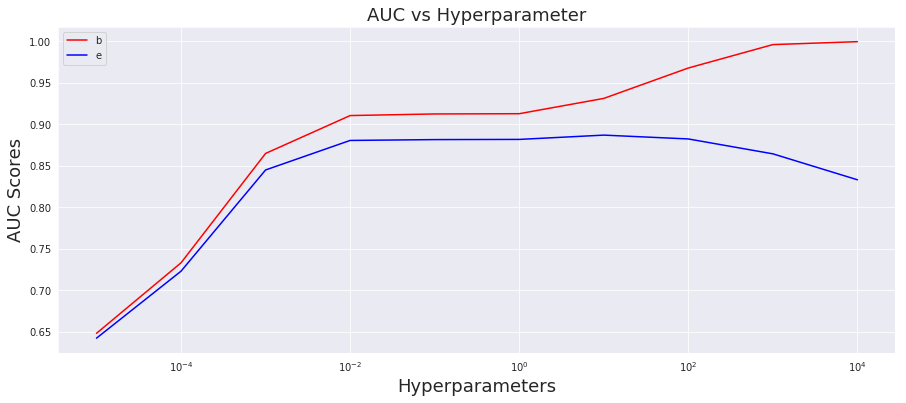

********************************************************************
AUC on Training data is: 0.9305006206297534
AUC on test data is: 0.8921253681079008


In [53]:
"""loading the model"""
svm_bow = pickle.load(open('gdrive/My Drive/svm_bow.p','rb'))#opening the file
print(svm_bow)
print('*****************************************************************')


"""plotting the AUC scores for tuning"""
best_C_bow = errors(svm_bow)['C']#optimal hyperparameter
print("********************************************************************")

"""Best Classifier"""
#we are initiating the best classifier here to reduce train complexity
svc = SVC(C = best_C_bow,gamma = 'auto',kernel = 'rbf',probability  = True)
svc.fit(train_bow,Y_train)#fitting to the model
train_bow_auc,test_bow_auc,train_proba,test_proba,train_pred,test_pred = best_classifier(svc,train_bow,Y_train,test_bow,Y_test)


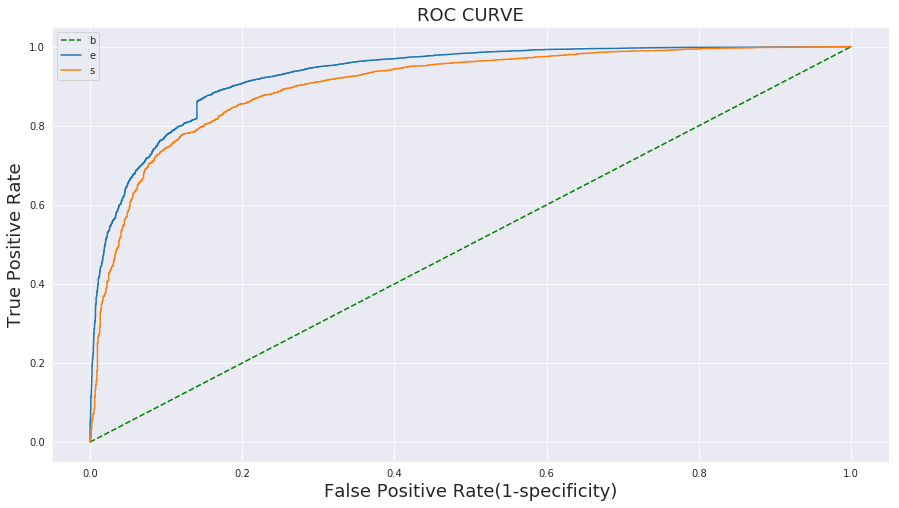

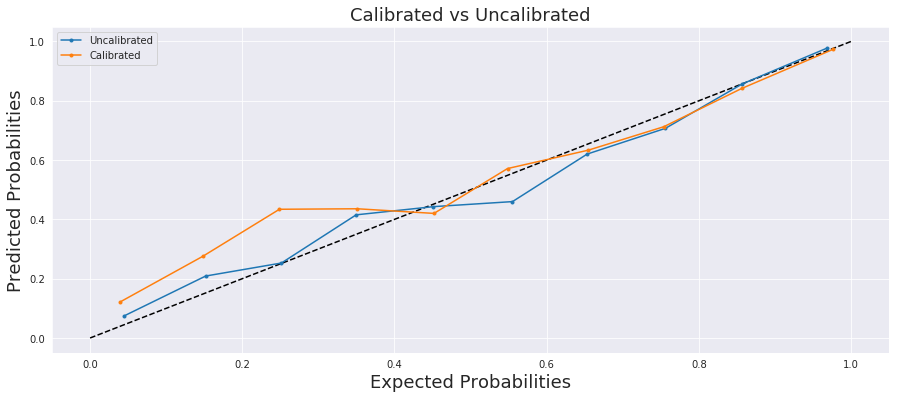

In [0]:
"""Plotting the ROC curve"""
plot_roc(Y_train,Y_test,train_proba,test_proba,train_bow_auc,test_bow_auc)


"""Reliability Curve"""
reliability_curve(svc,train_bow,test_bow,Y_train,Y_test)


for training data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

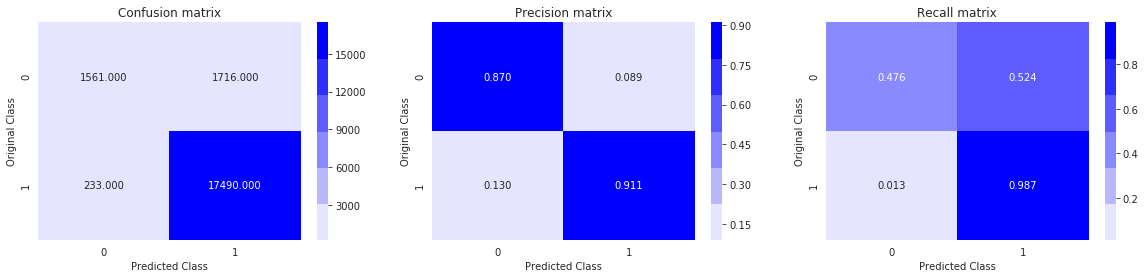

for test data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

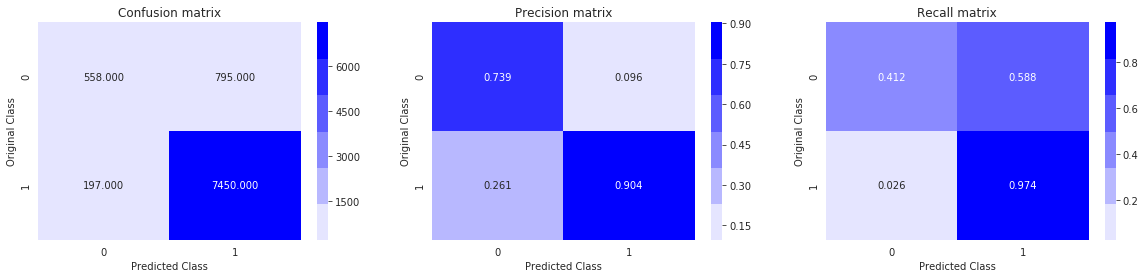

In [0]:
"""Confusion Matrices"""
print('for training data')
plot_cmatrix(Y_train,train_pred)

print('for test data')
plot_cmatrix(Y_test,test_pred)


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [55]:
svm_tfidf = svm(train_tfidf,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.2min finished


In [0]:
pickle.dump(svm_tfidf,open('gdrive/My Drive/svm_tfidf.p','wb'))#saving the model in drive

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)
*****************************************************************
best hyperparameter is : {'C': 10000}
best cross validation score is: 0.5130975592237403


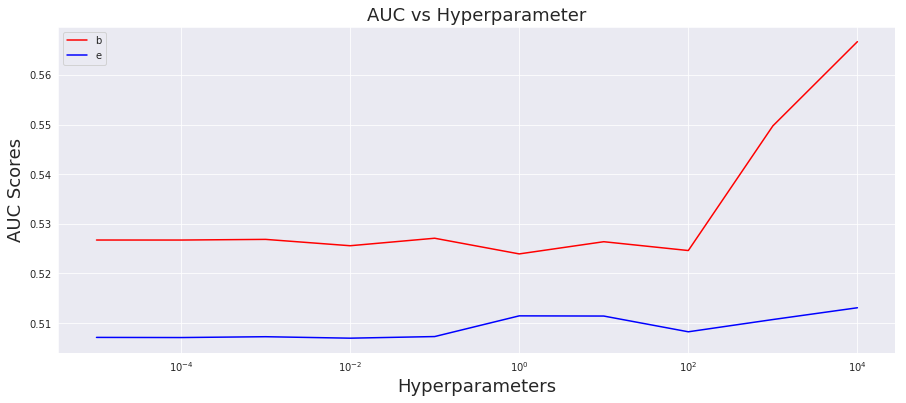

********************************************************************
AUC on Training data is: 0.5544149989982038
AUC on test data is: 0.5034864161501715


In [57]:
"""loading the model"""
svm_tfidf = pickle.load(open('gdrive/My Drive/svm_tfidf.p','rb'))#opening the file
print(svm_tfidf)
print('*****************************************************************')


"""plotting the AUC scores for tuning"""
best_C_tfidf = errors(svm_tfidf)['C']#optimal hyperparameter
print("********************************************************************")

"""Best Classifier"""
#we are initiating the best classifier here to reduce train complexity
svc = SVC(C = best_C_tfidf,gamma = 'auto',kernel = 'rbf',probability  = True)
svc.fit(train_tfidf,Y_train)#fitting to the model
train_tfidf_auc,test_tfidf_auc,train_proba,test_proba,train_pred,test_pred = best_classifier(svc,train_tfidf,Y_train,test_tfidf,Y_test)


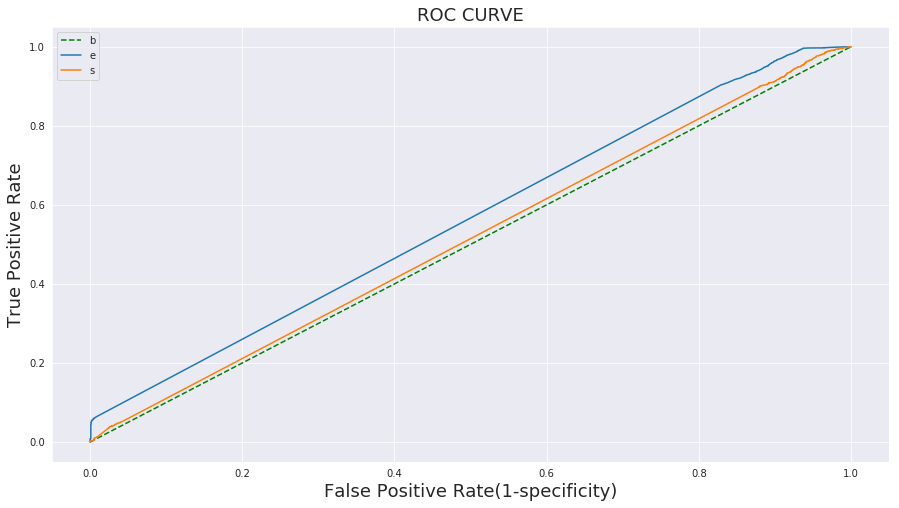

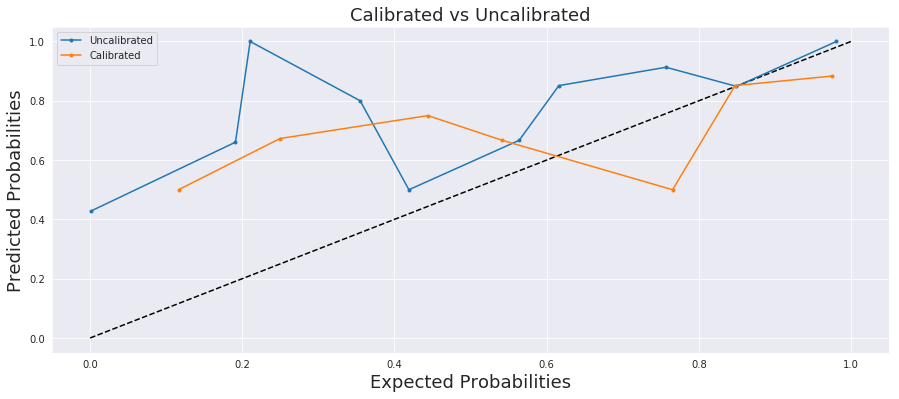

In [0]:
"""Plotting the ROC curve"""
plot_roc(Y_train,Y_test,train_proba,test_proba,train_tfidf_auc,test_tfidf_auc)


"""Reliability Curve"""
reliability_curve(svc,train_tfidf,test_tfidf,Y_train,Y_test)


for training data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

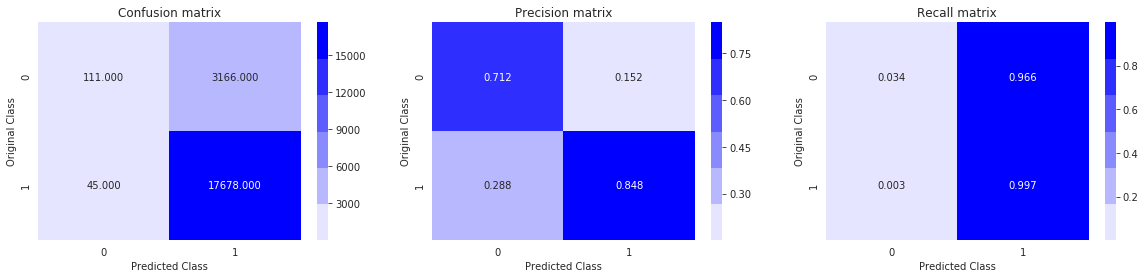

for test data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

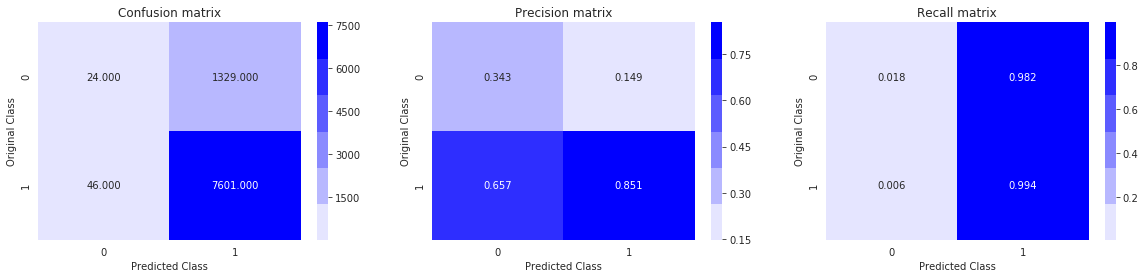

In [0]:
""Confusion Matrices"""
print('for training data')
plot_cmatrix(Y_train,train_pred)

print('for test data')
plot_cmatrix(Y_test,test_pred)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation
svm_avgw2v = svm(train_avgw2v,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 73.2min finished


In [0]:
pickle.dump(svm_avgw2v,open('gdrive/My Drive/svm_avgw2v.p','wb'))#saving the model in drive

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)
*****************************************************************
best hyperparameter is : {'C': 10}
best cross validation score is: 0.8877387558774296


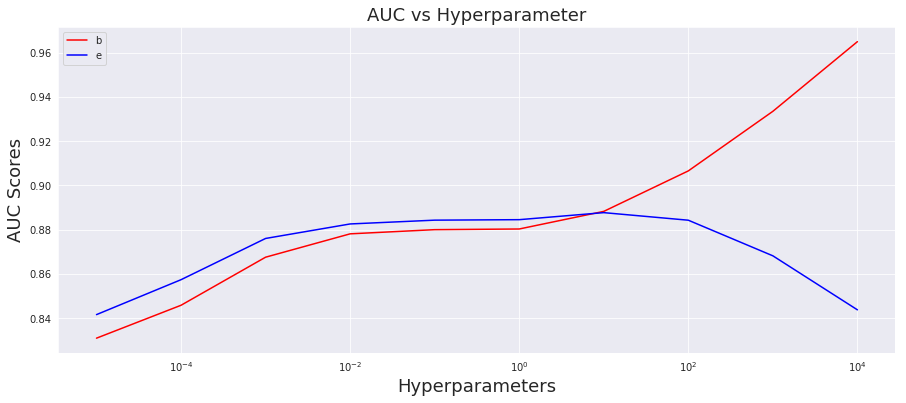

********************************************************************
AUC on Training data is: 0.8958923852149814
AUC on test data is: 0.8851873371524027


In [61]:
"""loading the model"""
svm_avgw2v = pickle.load(open('gdrive/My Drive/svm_avgw2v.p','rb'))#opening the file
print(svm_avgw2v)
print('*****************************************************************')


"""plotting the AUC scores for tuning"""
best_C_avgw2v = errors(svm_avgw2v)['C']#optimal hyperparameter
print("********************************************************************")

"""Best Classifier"""
#we are initiating the best classifier here to reduce train complexity
svc = SVC(C = best_C_avgw2v,gamma = 'auto',kernel = 'rbf',probability  = True)
svc.fit(train_avgw2v,Y_train)#fitting to the model
train_avgw2v_auc,test_avgw2v_auc,train_proba,test_proba,train_pred,test_pred = best_classifier(svc,train_avgw2v,Y_train,test_avgw2v,Y_test)


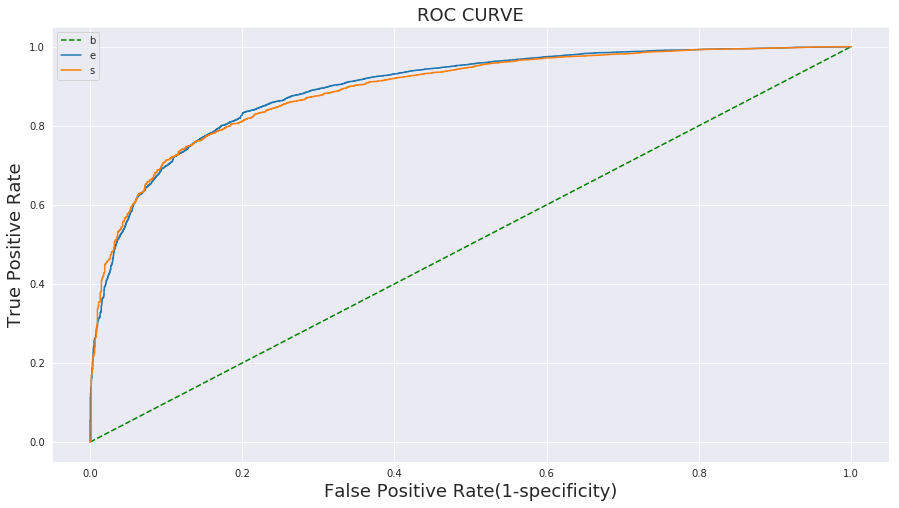

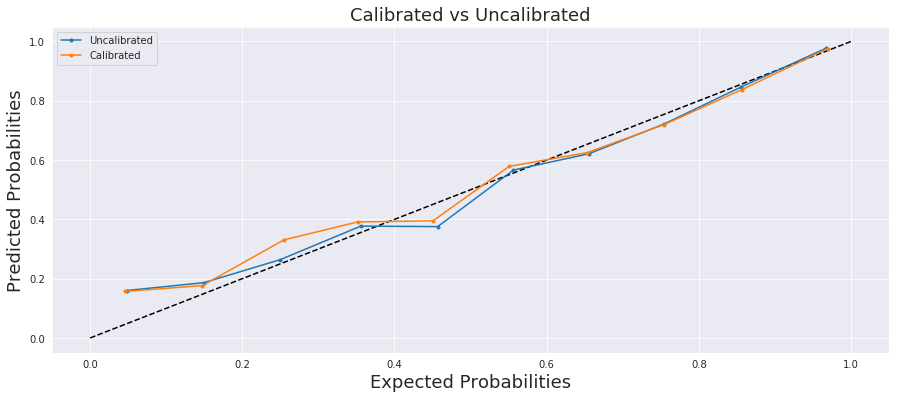

In [0]:
"""Plotting the ROC curve"""
plot_roc(Y_train,Y_test,train_proba,test_proba,train_avgw2v_auc,test_avgw2v_auc)


"""Reliability Curve"""
reliability_curve(svc,train_avgw2v,test_avgw2v,Y_train,Y_test)


for training data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

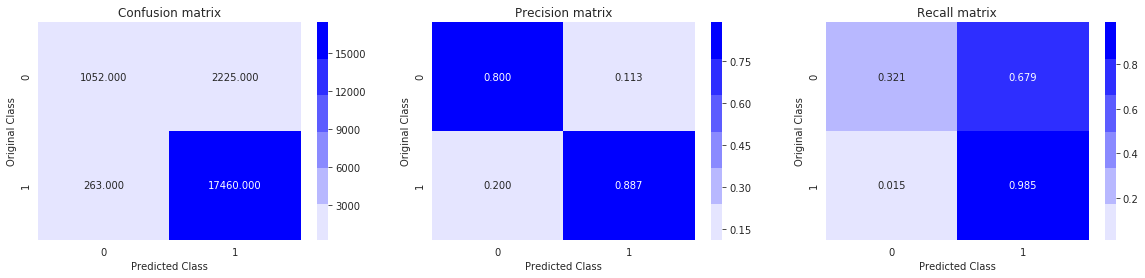

for test data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

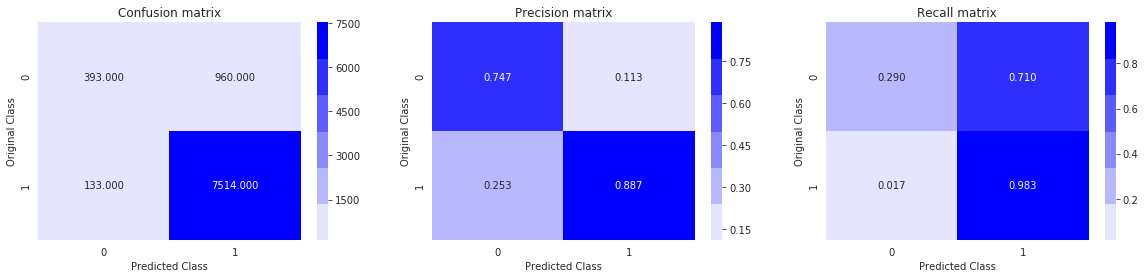

In [0]:
"""Confusion Matrices"""
print('for training data')
plot_cmatrix(Y_train,train_pred)

print('for test data')
plot_cmatrix(Y_test,test_pred)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [47]:
svm_tfidfw2v = svm(train_tfidfw2v,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 102.1min finished


In [0]:
pickle.dump(svm_tfidfw2v,open('gdrive/My Drive/svm_tfidfw2v.p','wb'))#saving the model in drive

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)
*****************************************************************
best hyperparameter is : {'C': 1}
best cross validation score is: 0.8401767620966667


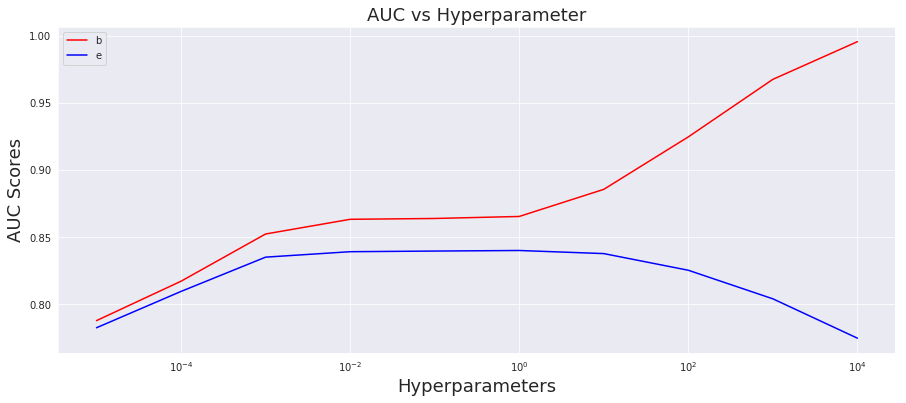

********************************************************************
AUC on Training data is: 0.8561757958119618
AUC on test data is: 0.8449966441232817


In [49]:
"""loading the model"""
svm_tfidfw2v = pickle.load(open('gdrive/My Drive/svm_tfidfw2v.p','rb'))#opening the file
print(svm_tfidfw2v)
print('*****************************************************************')


"""plotting the AUC scores for tuning"""
best_C_tfidfw2v = errors(svm_tfidfw2v)['C']#optimal hyperparameter
print("********************************************************************")

"""Best Classifier"""
#we are initiating the best classifier here to reduce train complexity
svc = SVC(C = best_C_tfidfw2v,gamma = 'auto',kernel = 'rbf',probability  = True)
svc.fit(train_tfidfw2v,Y_train)#fitting to the model
train_tfidfw2v_auc,test_tfidfw2v_auc,train_proba,test_proba,train_pred,test_pred = best_classifier(svc,train_tfidfw2v,Y_train,test_tfidfw2v,Y_test)


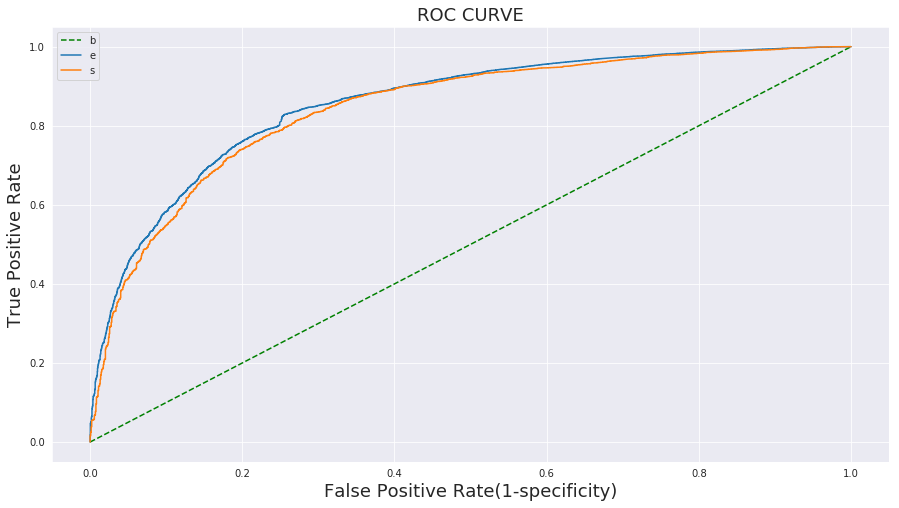

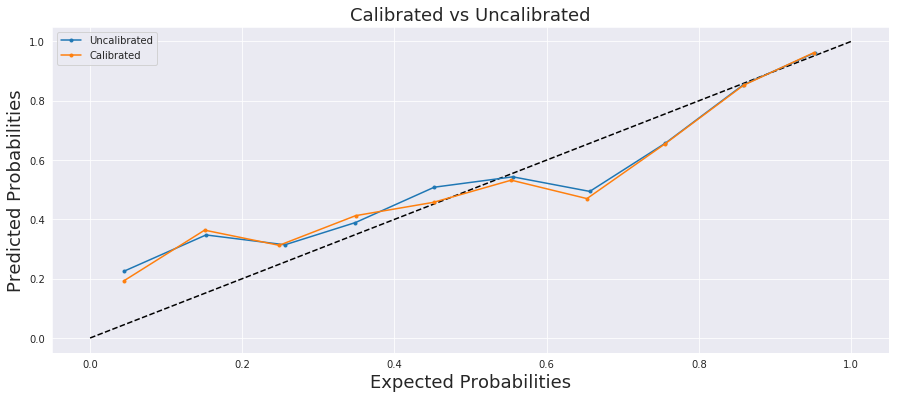

In [50]:
"""Plotting the ROC curve"""
plot_roc(Y_train,Y_test,train_proba,test_proba,train_tfidfw2v_auc,test_tfidfw2v_auc)


"""Reliability Curve"""
reliability_curve(svc,train_tfidfw2v,test_tfidfw2v,Y_train,Y_test)


for training data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

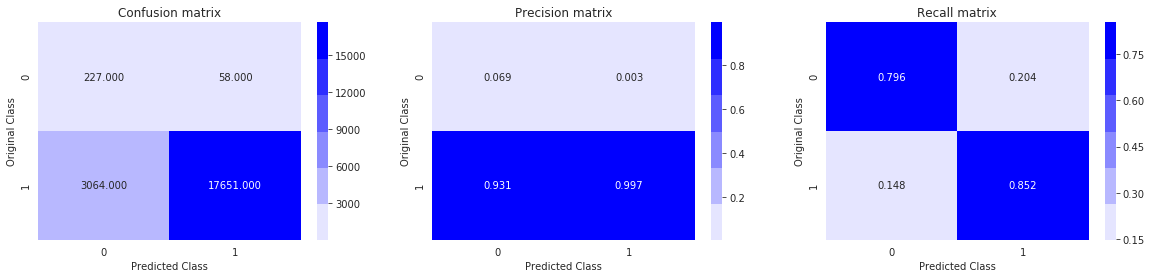

for test data
Confusion Matrix


<Figure size 1440x288 with 0 Axes>

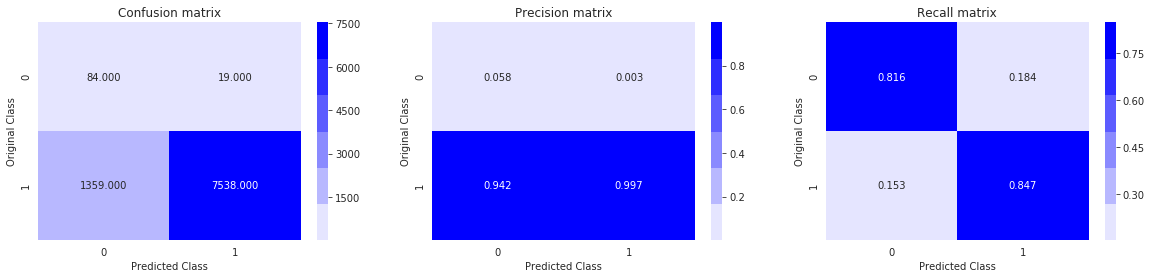

In [52]:
"""Confusion matrices"""
print('for training data')
plot_cmatrix(train_pred,Y_train)

print('for test data')
plot_cmatrix(test_pred,Y_test)

# [6] Conclusions

In [63]:
from prettytable import PrettyTable

table = PrettyTable()
no = [1,2,3,4,]
vectorizers = ['Bag of vectors','TFIDF','Average Word 2 vector','TFIDF Word 2 Vector']#all vectorizers
#regularization = ['l2','l1','l2','l1','l2','l1','l2','l1']
C = [best_C_bow,best_C_tfidf,best_C_avgw2v,best_C_tfidfw2v]
AUC = [test_bow_auc,test_tfidf_auc,test_avgw2v_auc,test_tfidfw2v_auc]#their respective auc scores

table.add_column("SNo",no)
table.add_column('Vectorizers',vectorizers)
#table.add_column('Regularization',regularization)
table.add_column('Hyperparameter(1/lambda)',C)
table.add_column('AUC on test',AUC)
print('\t\t\t Table for Support Vector Classifier')
print(table)

			 Table for Support Vector Classifier
+-----+-----------------------+--------------------------+--------------------+
| SNo |      Vectorizers      | Hyperparameter(1/lambda) |    AUC on test     |
+-----+-----------------------+--------------------------+--------------------+
|  1  |     Bag of vectors    |            10            | 0.8921253681079008 |
|  2  |         TFIDF         |          10000           | 0.5034864161501715 |
|  3  | Average Word 2 vector |            10            | 0.8851873371524027 |
|  4  |  TFIDF Word 2 Vector  |            1             | 0.8449966441232817 |
+-----+-----------------------+--------------------------+--------------------+


- In Support Vector Classifier BAG of Words stood out as the best featurizer with highest auc on test data.
- as C increase,i.e Lambda decreases the model tends to overfit .
